EnbPI Bootstrap Steps:
1) Extract and Clean Data
2) Preprocess Data
3) Bootstrap Synthetic Data
4) Train Bootstrap Models
5) LOO Predict and Mean Aggregate
6) Get Conformal Prediction Interval 
7) Get Coverage Rate on Test
8) Output Results

In [1]:
import numpy as np
import pandas as pd
from numpy.random import default_rng
from typing import Optional

from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from scipy import stats
from statsmodels.tsa.seasonal import STL
from scipy.special import boxcox, inv_boxcox
from sklearn.preprocessing import PowerTransformer
from statsmodels.tsa.arima.model import ARIMA

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Helper functions

# Step 1) Extract and Clean Data
def read_data(data_name, max_data_size):
    data_dir = "./Data"

    if data_name == "Solar_Atl":
        """
        4 (Alternative). NREL Solar data at Atlanta Downtown in 2018.
            - 24 observations per day and separately equally by 1H @ half an hour mark everytime
        Data descriptions see Solar Writeup
        Data download:
        (With API) https://nsrdb.nrel.gov/data-sets/api-instructions.html
        (Manual) https://maps.nrel.gov/nsrdb-viewer
        Properties:
            - Type: multivariate (5 temporal columns, 7 feature columns, 1 target)
            - Length: 8760
            - Period: entire 2018
            - Frequency: hourly (at every 30-min mark)
        """
        file_name = f"{data_name}_data.csv"
        data_df = pd.read_csv(file_name, skiprows=2)
        # data_df.shape  # 8760, 14
        data_df.drop(columns=data_df.columns[0:5], inplace=True)  # remove 5 temporal columns
        data_df.drop(columns="Unnamed: 13", inplace=True)
        # data_df.shape  # 8760, 8
        target_column = "DHI"

    elif data_name in _get_cali_cities():  # "Palo_Alto"
        """
        Properties:
            - Type: multivariate (1 datetime index, 5 temporal columns, 7 feature columns, 1 target)
            - Length: 8760
            - Period: entire 2018
            - Frequency: hourly
        """
        file_name = f"{data_name}_data.csv"
        data_df = pd.read_csv(file_name)
        data_df.drop(columns=data_df.columns[0:6], inplace=True)  # remove datetime index and 5 temporal columns
        target_column = "DHI"

    elif data_name == "appliances":
        """
        2. Appliances energy prediction Data Set
        The data set is at 10 min for about 4.5 months.
        The column named 'Appliances' is the response. Other columns are predictors
        https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
        Properties:
            - Type: multivariate (1 temporal column, 27 feature columns, 1 target)
            - Length: 19735
            - Period: 2016-01-11 @5PM to 2016-05-27 @6PM
            - Frequency: every 10-min
        """
        file_name = f"{data_name}_data.csv"
        data_df = pd.read_csv(file_name, delimiter=",")
        # data_df.shape  # (19736, 29)
        data_df.drop("date", inplace=True, axis=1)  # remove the temporal column
        data_df.loc[:, data_df.columns != "Appliances"]
        target_column = "Appliances"

    elif data_name == "green_house":
        """
        All datasets are Multivariate time-series. They have respective Github for more details as well.
        1. Greenhouse Gas Observing Network Data Set
        Time from 5.10-7.31, 2010, with 4 samples everyday, 6 hours apart between data poits.
        Goal is to "use inverse methods to determine the optimal values of the weights in the weighted sum of 15 tracers that best matches the synthetic observations"
        In other words, find weights so that first 15 tracers will be as close to the last as possible.
        Note, data at many other grid cells are available. Others are in Downloads/🌟AISTATS Data/Greenhouse Data
        https://archive.ics.uci.edu/ml/datasets/Greenhouse+Gas+Observing+Network
        Properties:
            - Type: multivariate (15 feature columns aka tracers(?), 1 target)
            - Length: 327
            - Period: 2010-05-10 to 2010-07-31
            - Frequency: every 6-hours
        """
        file_name = f"{data_name}_data.csv"
        data_df = pd.read_csv(file_name, header=None, sep=" ").T
        # data_df.shape  # 327, 16 Note, rows are 16 time series (first 15 from tracers, last from synthetic).
        target_column = 15

    elif data_name == "Beijing_air":
        """
        3. Beijing Multi-Site Air-Quality Data Data Set
        This data set includes hourly air pollutants data from 12 nationally-controlled air-quality monitoring sites.
        Time period from 3.1, 2013 to 2.28, 2017.
        PM2.5 or PM10 would be the response.
        https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data
        Properties:
            - Type: multivariate (1 index, 4 temporal columns, 12 feature columns, 1 target)
            - Length: 35064
            - Period: 2013-03-01 to 2017-02-28
            - Frequency: hourly
        """
        file_name = f"{data_name}_Tiantan_data.csv"
        data_df = pd.read_csv(file_name)
        # data_df.shape  # 35064, 18
        data_df.drop(
            columns=["No", "year", "month", "day", "hour", "wd", "station"],
            inplace=True,
            axis=1,
        )
        data_df.dropna(inplace=True)
        # data_df.shape  # 32907, 11
        target_column = "PM2.5"

    else:
        raise ValueError("data_name not found")   


    # pick maximum of X data points (for speed)
    data_df = data_df.iloc[: min(max_data_size, data_df.shape[0]), :]
    # shift target column back by one (for single-step forecast)
    data_df[target_column] = data_df[target_column].shift(-1)
    # remove final row as it does not contain target column value anymore
    data_df = data_df.iloc[:-1 , :]        

    return data_df, target_column


def _get_cali_cities():
    cali_cities = [
        "Fremont",
        "Milpitas",
        "Mountain_View",
        "North_San_Jose",
        "Palo_Alto",
        "Redwood_City",
        "San_Mateo",
        "Santa_Clara",
        "Sunnyvale",
    ]
    return cali_cities


# Step 2) this is the AR-transformer. can replace with something from sktime.  ################
def one_dimen_transform(y_train, y_test, n_lags):
    n = len(y_train)
    n1 = len(y_test)
    X_train = np.zeros((n - n_lags, n_lags))  # from n_lags+1,...,n
    X_test = np.zeros((n1, n_lags))  # from n-n_lags,...,n+n1-n_lags
    for i in range(n - n_lags):
        X_train[i, :] = y_train[i : i + n_lags]
    for i in range(n1):
        if i < n_lags:
            X_test[i, :] = np.r_[y_train[n - n_lags + i :], y_test[:i]]
        else:
            X_test[i, :] = y_test[i - n_lags : i]
    y_train = y_train[n_lags:]
    return [X_train, X_test, y_train, y_test]


# Step 3) ################
def generate_bootstrap_samples(n, m, B, bootstrap_type, block_length, random_seed):
    samples_idx = np.zeros((B, m), dtype=int)

    for b in range(B):
        if bootstrap_type == "random":  # RB
            np.random.seed(b + random_seed)
            sample_idx = np.random.choice(a=n, size=m, replace=True)
        elif bootstrap_type == "nonoverlapping":  # NBB
            sample_idx = _id_nbb_bootstrap(
                n_obs=n, block_length=block_length, random_seed=b + random_seed,
            )
        elif bootstrap_type == "moving":  # MBB
            sample_idx = _id_mbb_bootstrap(
                n_obs=n, block_length=block_length, random_seed=b + random_seed,
            )
        elif bootstrap_type == "circular":  # CBB
            sample_idx = _id_cbb_bootstrap(
                n_obs=n, block_length=block_length, random_seed=b + random_seed,
            )
        elif bootstrap_type == "stationary":  # SBB
            sample_idx = _id_sbb_bootstrap(
                n_obs=n, block_length=block_length, random_seed=b + random_seed,
            )
        else:
            raise ValueError("boostrap_type not supported")      
        samples_idx[b, :] = sample_idx

    return samples_idx


# Non-overlapping block bootstrap (NBB)
def _id_nbb_bootstrap(
    n_obs: int, block_length: int, random_seed: Optional[int] = 10
) -> np.ndarray:
    """Create bootstrapped indexes with the none overlapping block bootstrap
    ('nbb') strategy given the number of observations in a timeseries and
    the length of the blocks.
    Returns
    -------
    _id : array
        Bootstrapped indexes.
    """
    rng = default_rng(random_seed)
    
    n_blocks = int(np.ceil(n_obs / block_length))
    nexts = np.repeat([np.arange(0, block_length)], n_blocks, axis=0)
    
    blocks = rng.permutation(x=np.arange(0, n_obs, block_length)).reshape(-1, 1)
    _id = (blocks + nexts).ravel()[:n_obs]

    return _id


# Moving block bootstrap (MBB)
def _id_mbb_bootstrap(
    n_obs: int, block_length: int, random_seed: Optional[int]=10
) -> np.ndarray:
    """Create bootstrapped indexes with the moving block bootstrap
    ('mbb') strategy given the number of observations in a timeseries
    and the length of the blocks.
    Returns
    -------
    _id : array
        Bootstrapped indexes.
    """
    rng = default_rng(random_seed)
    try:
        rng_integers = rng.integers
    except AttributeError:
        rng_integers = rng.randint

    n_blocks = int(np.ceil(n_obs / block_length))
    nexts = np.repeat([np.arange(0, block_length)], n_blocks, axis=0)
    
    last_block = n_obs - block_length
    blocks = rng_integers(low=0, high=last_block, size=(n_blocks, 1), dtype=int)
    _id = (blocks + nexts).ravel()[:n_obs]

    return _id


# Circular block bootstrap (MBB)
def _id_cbb_bootstrap(
    n_obs: int, block_length: int, random_seed: Optional[int]=10
) -> np.ndarray:
    """Create bootstrapped indexes with the circular block bootstrap
    ('cbb') strategy given the number of observations in a timeseries
    and the length of the blocks.
    Returns
    -------
    _id : array
        Bootstrapped indexes.
    """
    rng = default_rng(random_seed)
    try:
        rng_integers = rng.integers
    except AttributeError:
        rng_integers = rng.randint

    n_blocks = int(np.ceil(n_obs / block_length))
    nexts = np.repeat([np.arange(0, block_length)], n_blocks, axis=0)
    
    last_block = n_obs
    blocks = rng_integers(low=0, high=last_block, size=(n_blocks, 1), dtype=int)
    _id = np.mod((blocks + nexts).ravel(), n_obs)[:n_obs]

    return _id


# Stationary block bootstrap (SBB)
def _id_sbb_bootstrap(
    n_obs: int, block_length: int, random_seed: Optional[int]=10
) -> np.ndarray:
    """Create bootstrapped indexes with the stationary block bootstrap
    ('sb') strategy given the number of observations in a timeseries
    and the length of the blocks.
    Returns
    -------
    _id : array
        Bootstrapped indexes.
    """
    rng = default_rng(random_seed)
    try:
        rng_integers = rng.integers
    except AttributeError:
        rng_integers = rng.randint
    #
    rng_poisson = rng.poisson
    #
    random_block_length = rng_poisson(lam=block_length, size=n_obs)
    random_block_length[random_block_length < 3] = 3
    random_block_length[random_block_length >= n_obs] = n_obs
    random_block_length = random_block_length[random_block_length.cumsum() <= n_obs]
    residual_block = n_obs - random_block_length.sum()
    if residual_block > 0:
        random_block_length = np.append(random_block_length, residual_block)
    #
    n_blocks = random_block_length.shape[0]
    nexts = np.zeros((n_blocks, random_block_length.max() + 1))
    nexts[np.arange(n_blocks), random_block_length] = 1
    nexts = np.flip(nexts, 1).cumsum(1).cumsum(1).ravel()
    nexts = (nexts[nexts > 1] - 2).astype(int)
    #
    last_block = n_obs - random_block_length.max()
    blocks = np.zeros(n_obs, dtype=int)
    if last_block > 0:
        blocks = rng_integers(low=0, high=last_block, size=n_blocks)
        blocks = np.repeat(blocks, random_block_length)
    _id = blocks + nexts
    #
    return _id


# Step 4) ################
def initiate_regressor(model_type):
    min_alpha = 0.0001
    max_alpha = 10

    if model_type == "lasso":
        model = LassoCV(alphas=np.linspace(min_alpha, max_alpha, 10))
    elif model_type == "ridge":
        model = RidgeCV(alphas=np.linspace(min_alpha, max_alpha, 10))
    elif model_type == "random_forest":
        model = RandomForestRegressor(
            n_estimators=10,
            criterion="squared_error",
            bootstrap=False,
            max_depth=2,
            n_jobs=-1,
        )
    elif model_type == "extra_trees":
        model = ExtraTreesRegressor(
            n_estimators=10,
            criterion="squared_error",
            bootstrap=False,
            max_depth=2,
            n_jobs=-1
        )
    elif model_type == "linear":
        model = LinearRegression()
    elif model_type == "logistic":
        model = LogisticRegressionCV()
    else:
        raise ValueError("model_type not supported")

    return model

In [3]:
#Decomposing Seasonal and trend components
def decompose(data, type_="stl"):
    if type_=="stl":
        stl_model=STL(data, period=24, seasonal=7)
        res=stl_model.fit()
        seasonal=res.seasonal
        trend=res.trend
        residual=res.resid
    return seasonal, trend, residual

#  Testing with Simulated Gaussian WN~(0,1) data

## One Trial for each combination of parameters

In [4]:
#Simulate Gaussian white noises ~(0,1)
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot
# seed random number generator
seed(1)
# create white noise series
series = [gauss(0.0, 1.0) for i in range(1000)]
series = Series(series)

Matplotlib is building the font cache; this may take a moment.


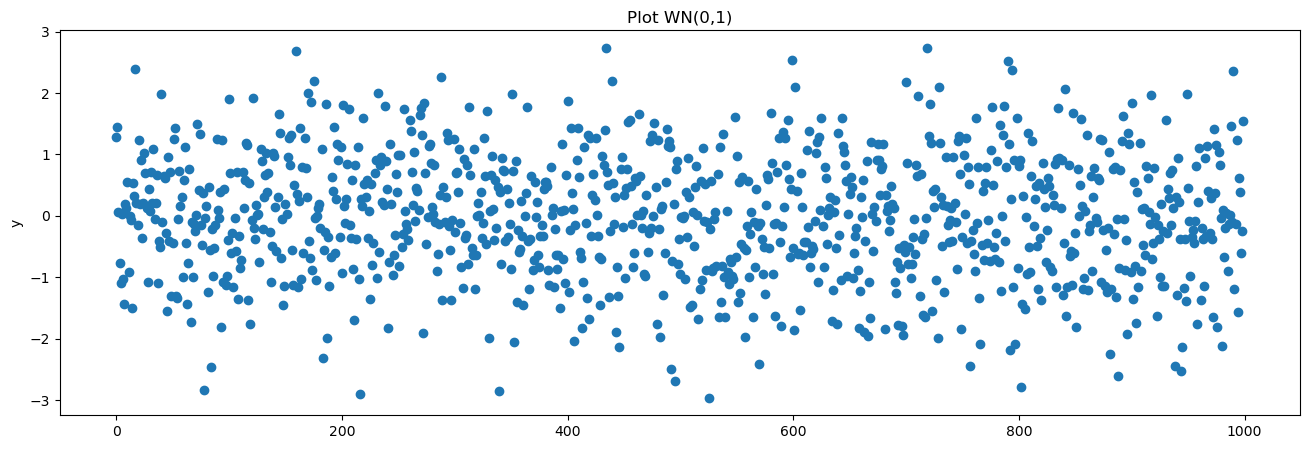

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 5))
plt.scatter(series.index, series)
plt.ylabel("y")
plt.title('Plot WN(0,1)')
plt.show()

In [6]:
series.describe()

count    1000.000000
mean       -0.013222
std         1.003685
min        -2.961214
25%        -0.684192
50%        -0.010934
75%         0.703915
max         2.737260
dtype: float64

In [7]:
series

0      1.288185
1      1.449446
2      0.066336
3     -0.764544
4     -1.092173
         ...   
995    0.619316
996    0.395090
997   -0.602409
998   -0.240635
999    1.546682
Length: 1000, dtype: float64

In [9]:
# Main executable function

def enbpi_exec_wn(
    data,
    train_fractions,
    method,
    B_list,
    bootstrap_types,
    block_lengths,
    model_types,
    alphas,
    itrial=0,
    n_lags=1,
    output_name = "many_data",
    verbose=1,
):

    # STEP 1): Preprocess Data ################
    tab_str = "- "
    for train_fraction in train_fractions:
        tab_str = "  " + tab_str
        if verbose >= 1: print(f"\n{tab_str}train_fraction={train_fraction}")
        # 2a) Split train/test sets
        # get WN series data
        data_y = data
        # convert WN series data to numpy
        data_y_numpy = data_y.to_numpy()
        # get train idx to split train and test
        train_size = int(len(series) * train_fraction)
        # split into 4
        y_train_numpy = data_y_numpy[:train_size]
        y_test_numpy = data_y_numpy[train_size:]
        # 2b) Get AR coeffs (optional)
        X_train, X_test, y_train, y_test = one_dimen_transform(
                            y_train_numpy,
                            y_test_numpy,
                            n_lags=n_lags,  # d
                        )
        tab_str = "  " + tab_str
        if verbose == 2: 
            print(f"{tab_str}X_train shape: {X_train.shape}")
            print(f"{tab_str}X_test shape: {X_test.shape}")
            print(f"{tab_str}y_train shape: {y_train.shape}")
            print(f"{tab_str}y_test shape: {y_test.shape}")

        results_df = pd.DataFrame()
        # STEP 3) Bootstrap Synthetic Data ################
        for B in B_list:
            for bootstrap_type in bootstrap_types:
                for block_length in block_lengths:
                    if verbose >= 1:
                        print(f"{tab_str}B={B}, bootstrap_type='{bootstrap_type}', block_length={block_length}")
                    n = len(X_train)
                    n1 = len(X_test)
                    m = n
                    # tot_trial = 1    # For CP method that randomizes (for EnbPI, should be set to 1)
                    itrial = itrial  # for tot_trial in range(tot_trial)
                    random_seed = B + itrial
                    boot_samples_idx = generate_bootstrap_samples(
                        n=n,
                        m=m,
                        B=B,
                        bootstrap_type=bootstrap_type,
                        block_length=block_length,
                        random_seed=random_seed,
                    )
                    tab_str = "  " + tab_str
                    if verbose == 2: print(f"{tab_str}Bootstrap samples indexes shape: {boot_samples_idx.shape}")
                    # print(boot_samples_idx)

                    # STEP 4) Train Bootstrapped Models ################
                    # tab_str = "  " + tab_str    
                    for model_type in model_types:
                        # if verbose >= 1: print(f"{tab_str}model_type='{model_type}'")
                        # hold predictions from each f^b
                        boot_predictions = np.zeros((B, (n + n1)), dtype=float)
                        # for i^th column, it shows which f^b uses i in training (so exclude in aggregation)
                        in_boot_sample = np.zeros((B, n), dtype=bool)
                        for b in range(B):
                            X_train_boot = X_train[boot_samples_idx[b], :]
                            y_train_boot = y_train[boot_samples_idx[b],]
                            model = initiate_regressor(model_type)
                            model.fit(
                                X_train_boot,
                                y_train_boot,
                                # epochs=10,
                                # batch_size=bsize,
                                # callbacks=[callback],
                                # verbose=0,
                            )
                            # Model's prediction for every observation on every bootstrapped data
                            boot_predictions[b] = model.predict(np.r_[X_train, X_test]).flatten()
                            # Whether a observation in the training data is sampled for the given bootstrapped data
                            # If it is true, then this observation should NOT be used for model prediction
                            in_boot_sample[b, boot_samples_idx[b]] = True
                        tab_str = "  " + tab_str
                        if verbose == 2:
                            print(f"{tab_str}boot_predictions shape: {boot_predictions.shape}")
                            print(f"{tab_str}in_boot_sample shape: {in_boot_sample.shape}")

                        # STEP 5) LOO Predict and Mean Aggregate
                        y_in_pred = np.zeros(n)          # Mean aggregated predict on in-sample train set
                        y_LOO_preds = np.zeros((n, n1))  # Non-aggregated predict on OOS test set
                        y_pred = np.zeros(n1)            # Aggregated predict on OOS test set

                        ensemble_online_resid = np.array([])    # LOO scores
                        # LOO in-sample train predict and OOS test predict 
                        for i in range(n):
                            b_keep = np.argwhere(~(in_boot_sample[:, i])).reshape(-1)
                            if len(b_keep) > 0:
                                # Get the LOO predictions for i for both in-sample and OOS
                                y_train_LOO_boot_preds = boot_predictions[b_keep, i]
                                y_in_pred[i] = y_train_LOO_boot_preds.mean()  # Mean aggregate to form a scalar value
                                y_LOO_boot_preds = boot_predictions[b_keep, n:]
                                y_LOO_preds[i] = y_LOO_boot_preds.mean(0)
                            else:  # if aggregating an empty set of models, predict zero everywhere
                                if verbose == 2: print(f"{tab_str}  WARNING: no bootstrapped models available for i={i}")
                        y_pred = y_LOO_preds.mean(0)
                        if verbose == 2:
                            print(f"{tab_str}y_in_pred shape: {y_in_pred.shape}")
                            print(f"{tab_str}y_pred shape: {y_pred.shape}")
                            print(f"{tab_str}  y_LOO_preds shape: {y_LOO_preds.shape}")

                        # STEP 6) Aggregate Model with LOO
                        for alpha in alphas:
                            # if verbose >= 1: print(f"{tab_str}alpha={alpha}")
                            # Get absolute residual and sort
                            abs_resid = np.abs(np.subtract(y_train, y_in_pred))
                            abs_resid.sort()
                            # Get q-hat value
                            q_idx = int(-len(abs_resid)*alpha)
                            q_hat = abs_resid[q_idx]
                            # Evaluation metric 1: PI width
                            width = round(q_hat*2, 6)
                            tab_str = "  " + tab_str
                            if verbose == 2: print(f"{tab_str}width={width}")

                            # STEP 7) Get Coverage Rate from Test
                            # Get OOS absolute residual and sort
                            oos_abs_resid = np.abs(np.subtract(y_test, y_pred))
                            oos_abs_resid.sort()
                            # Count number of residuals below or equal to q_hat, or within the interval width.
                            n_coverage = np.asarray(oos_abs_resid <= q_hat).sum()
                            # Evaluation metric 2: Coverage rate
                            coverage = round(n_coverage/n1, 6)
                            if verbose == 2: print(f"{tab_str}coverage={coverage}")
                            """
                            NOTE: I am using the symmetical conformal prediction (like in NP), instead of the
                                  fancy method that Chen did. That is why the coverage rate is near the 
                                  theroretical guarantee limit of 2*alpha.
                            """

                            #### STEP 8) Output Results
                            results_row = {
                                "data_name": "Gauss WN~(0,sigma^2)",
                                "itrial": itrial,
                                "B": B,
                                "bootstrap_type": bootstrap_type,
                                "block_length": block_length,
                                "model_type": model.__class__.__name__,  # "muh_fun"
                                "method": method,
                                "alpha": alpha,
                                "width": width,    
                                "coverage": coverage,
                            }
                            results_df = pd.concat([results_df, pd.DataFrame([results_row])], ignore_index=True)

                            tab_str = tab_str[2:]
                        tab_str = tab_str[2:]
                    tab_str = tab_str[2:]
        tab_str = tab_str[4:]

    results_df.to_csv(f'Results/{output_name}_EnbPI.csv', index=False)

In [10]:
# Params
# Step 1) params
# cali_cities = ["Palo_Alto"]
# data_list = _get_cali_cities()
# data_list = ["Solar_Atl"] + cali_cities + ["appliances", "Beijing_air"]
#data_list = ["Solar_Atl"]
#max_data_size = 10000
data=series
# Step 2) params
# train_fractions = [0.1, 0.2]
train_fractions = [0.8]
# train_fractions = [0.7, 0.8]
# train_fractions = [0.3, 0.4, 0.5, 0.6, 0.7]  # EnbPI WP Pg. 8
# print(train_fractions)
# one_dim_list = [True]
#one_dim_list = [False]
n_lags = 24  # 'n_lags' aka 'd` is num_lookbacks for AR-transformer

# Step 3) params
itrial = 0
B_list = [30,40,50]  # number of bootstraps list
# B_list = [20, 25, 30, 35, 40, 45, 50]  # EnbPI WP Pg. 11: between 20-50 is sufficient
# bootstrap_types = ["random", "moving"]  # "nonoverlapping" has problem -> IndexError: index 851 is out of bounds for axis 0 with size 851
bootstrap_types = ["random", "moving", "circular"]
block_lengths = [6, 12, 24]
# block_lengths = [6, 12, 24, 48, 60, 72]

# Step 4) params
# model_types = ["ridge", "random_forest"]  # muh_fun
model_types = ["linear", "lasso", "ridge", "random_forest"]  # "neural_networks"
method = "Ensemble"

# Step 6) params
alphas = [0.05, 0.1]
# alphas = [0.05, 0.1, 0.15, 0.2, 0.25]  # EnbPI WP Pg. 17: five equally spaces 1-a [0.75, 0.95] are chosen
# alphas = [0.01, 0.10, 0.20, 0.50, 0.80, 0.90, 0.99]
# alphas = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]

# Step 8) params
output_name = "Gauss_White_Noises"
verbose = 1  # 0 no print statement, 1 only params, 2 everything

In [11]:
%%time
# Execute!

enbpi_exec_wn(
    # Step 1) Extract Data
    data=series,
    # Step 2) Preprocess Data
    train_fractions=train_fractions,
    n_lags=n_lags,
    # Step 3) Preprocess Data
    itrial=itrial,
    B_list=B_list,
    bootstrap_types=bootstrap_types,
    block_lengths=block_lengths,
    # STEP 4) Train Bootstrapped Models
    model_types=model_types,
    method=method,
    # STEP 6) Get Conformal Prediction Interval
    alphas=alphas,
    # STEP 8) Output Results
    output_name=output_name,
    verbose=verbose,
)


  - train_fraction=0.8
    - B=30, bootstrap_type='random', block_length=6
    - B=30, bootstrap_type='random', block_length=12
    - B=30, bootstrap_type='random', block_length=24
    - B=30, bootstrap_type='moving', block_length=6
    - B=30, bootstrap_type='moving', block_length=12
    - B=30, bootstrap_type='moving', block_length=24
    - B=30, bootstrap_type='circular', block_length=6
    - B=30, bootstrap_type='circular', block_length=12
    - B=30, bootstrap_type='circular', block_length=24
    - B=40, bootstrap_type='random', block_length=6
    - B=40, bootstrap_type='random', block_length=12
    - B=40, bootstrap_type='random', block_length=24
    - B=40, bootstrap_type='moving', block_length=6
    - B=40, bootstrap_type='moving', block_length=12
    - B=40, bootstrap_type='moving', block_length=24
    - B=40, bootstrap_type='circular', block_length=6
    - B=40, bootstrap_type='circular', block_length=12
    - B=40, bootstrap_type='circular', block_length=24
    - B=50, boot

In [13]:
res_wn_var1=pd.read_csv(f'Results/Gauss_White_Noises_EnbPI.csv')

In [14]:
res_wn_var1

,data_name,itrial,B,bootstrap_type,block_length,model_type,method,alpha,width,coverage
0,"Gauss WN~(0,sigma^2)",0,30,random,6,LinearRegression,Ensemble,0.05,4.019656,0.945
1,"Gauss WN~(0,sigma^2)",0,30,random,6,LinearRegression,Ensemble,0.10,3.292577,0.875
2,"Gauss WN~(0,sigma^2)",0,30,random,6,LassoCV,Ensemble,0.05,3.943646,0.945
3,"Gauss WN~(0,sigma^2)",0,30,random,6,LassoCV,Ensemble,0.10,3.377647,0.905
4,"Gauss WN~(0,sigma^2)",0,30,random,6,RidgeCV,Ensemble,0.05,4.017402,0.945
...,...,...,...,...,...,...,...,...,...,...
211,"Gauss WN~(0,sigma^2)",0,50,circular,24,LassoCV,Ensemble,0.10,3.340857,0.900
212,"Gauss WN~(0,sigma^2)",0,50,circular,24,RidgeCV,Ensemble,0.05,3.977943,0.945
213,"Gauss WN~(0,sigma^2)",0,50,circular,24,RidgeCV,Ensemble,0.10,3.318522,0.895
214,"Gauss WN~(0,sigma^2)",0,50,circular,24,RandomForestRegressor,Ensemble,0.05,3.907093,0.945


In [15]:
res_wn_var1.groupby(by=['B','model_type','alpha']).mean('coverage').drop(columns=['itrial','block_length'])

width  coverage
B  model_type            alpha                    
30 LassoCV               0.05   3.963313  0.945000
                         0.10   3.335317  0.902222
   LinearRegression      0.05   4.012445  0.945000
                         0.10   3.283235  0.881111
   RandomForestRegressor 0.05   3.920709  0.946111
                         0.10   3.399033  0.903333
   RidgeCV               0.05   4.010096  0.945000
                         0.10   3.283454  0.882778
40 LassoCV               0.05   3.968167  0.945000
                         0.10   3.338713  0.905000
   LinearRegression      0.05   4.017810  0.945000
                         0.10   3.300747  0.887222
   RandomForestRegressor 0.05   3.898044  0.944444
                         0.10   3.373620  0.900000
   RidgeCV               0.05   4.016056  0.945000
                         0.10   3.299035  0.886667
50 LassoCV               0.05   3.968058  0.945000
                         0.10   3.328978  0.903889
   LinearRegression      0.05   4.031202  0.945000
                         0.10   3.289386  0.886111
   RandomForestRegressor 0.05   3.915854  0.943333
                         0.10   3.377273  0.904444
   RidgeCV               0.05   4.031017  0.945000
                         0.10   3.289792  0.887778

In [16]:
res_wn_var1.groupby(by=['alpha']).mean('coverage').drop(columns=['B','itrial','block_length'])

,width,coverage
alpha,,
0.05,3.979398,0.944907
0.10,3.324882,0.894213


## 2000 trials (only 1 combination of parameters)

In [54]:
# Main executable function

def enbpi_wn_large(
    data,
    train_fractions,
    method,
    B_list,
    bootstrap_types,
    block_lengths,
    model_types,
    alphas,
    itrial=10,
    n_lags=1,
    output_name = "many_data",
    verbose=1,
):
    coverage_list=[]
    # STEP 1): Preprocess Data ################
    tab_str = "- "
    for train_fraction in train_fractions:
        tab_str = "  " + tab_str
        if verbose >= 1: print(f"\n{tab_str}train_fraction={train_fraction}")
        # 2a) Split train/test sets
        # get WN series data
        data_y = data
        # convert WN series data to numpy
        data_y_numpy = data_y.to_numpy()
        # get train idx to split train and test
        train_size = int(len(series) * train_fraction)
        # split into 4
        y_train_numpy = data_y_numpy[:train_size]
        y_test_numpy = data_y_numpy[train_size:]
        # 2b) Get AR coeffs (optional)
        X_train, X_test, y_train, y_test = one_dimen_transform(
                            y_train_numpy,
                            y_test_numpy,
                            n_lags=n_lags,  # d
                        )
        tab_str = "  " + tab_str
        if verbose == 2: 
            print(f"{tab_str}X_train shape: {X_train.shape}")
            print(f"{tab_str}X_test shape: {X_test.shape}")
            print(f"{tab_str}y_train shape: {y_train.shape}")
            print(f"{tab_str}y_test shape: {y_test.shape}")

        results_df = pd.DataFrame()
        # STEP 3) Bootstrap Synthetic Data ################
        for trial in range(itrial):
            for B in B_list:
                for bootstrap_type in bootstrap_types:
                    for block_length in block_lengths:
                        if verbose >= 1:
                            print(f"{tab_str}B={B}, trial={trial}, bootstrap_type='{bootstrap_type}', block_length={block_length}")
                        n = len(X_train)
                        n1 = len(X_test)
                        m = n
                        # tot_trial = 1    # For CP method that randomizes (for EnbPI, should be set to 1)
                        itrial = trial  # for tot_trial in range(tot_trial)
                        random_seed = B + itrial
                        boot_samples_idx = generate_bootstrap_samples(
                            n=n,
                            m=m,
                            B=B,
                            bootstrap_type=bootstrap_type,
                            block_length=block_length,
                            random_seed=random_seed,
                        )
                        tab_str = "  " + tab_str
                        if verbose == 2: print(f"{tab_str}Bootstrap samples indexes shape: {boot_samples_idx.shape}")
                        # print(boot_samples_idx)

                        # STEP 4) Train Bootstrapped Models ################
                        # tab_str = "  " + tab_str    
                        for model_type in model_types:
                            # if verbose >= 1: print(f"{tab_str}model_type='{model_type}'")
                            # hold predictions from each f^b
                            boot_predictions = np.zeros((B, (n + n1)), dtype=float)
                            # for i^th column, it shows which f^b uses i in training (so exclude in aggregation)
                            in_boot_sample = np.zeros((B, n), dtype=bool)
                            for b in range(B):
                                X_train_boot = X_train[boot_samples_idx[b], :]
                                y_train_boot = y_train[boot_samples_idx[b],]
                                model = initiate_regressor(model_type)
                                model.fit(
                                    X_train_boot,
                                    y_train_boot,
                                    # epochs=10,
                                    # batch_size=bsize,
                                    # callbacks=[callback],
                                    # verbose=0,
                                )
                                # Model's prediction for every observation on every bootstrapped data
                                boot_predictions[b] = model.predict(np.r_[X_train, X_test]).flatten()
                                # Whether a observation in the training data is sampled for the given bootstrapped data
                                # If it is true, then this observation should NOT be used for model prediction
                                in_boot_sample[b, boot_samples_idx[b]] = True
                            tab_str = "  " + tab_str
                            if verbose == 2:
                                print(f"{tab_str}boot_predictions shape: {boot_predictions.shape}")
                                print(f"{tab_str}in_boot_sample shape: {in_boot_sample.shape}")

                            # STEP 5) LOO Predict and Mean Aggregate
                            y_in_pred = np.zeros(n)          # Mean aggregated predict on in-sample train set
                            y_LOO_preds = np.zeros((n, n1))  # Non-aggregated predict on OOS test set
                            y_pred = np.zeros(n1)            # Aggregated predict on OOS test set

                            ensemble_online_resid = np.array([])    # LOO scores
                            # LOO in-sample train predict and OOS test predict 
                            for i in range(n):
                                b_keep = np.argwhere(~(in_boot_sample[:, i])).reshape(-1)
                                if len(b_keep) > 0:
                                    # Get the LOO predictions for i for both in-sample and OOS
                                    y_train_LOO_boot_preds = boot_predictions[b_keep, i]
                                    y_in_pred[i] = y_train_LOO_boot_preds.mean()  # Mean aggregate to form a scalar value
                                    y_LOO_boot_preds = boot_predictions[b_keep, n:]
                                    y_LOO_preds[i] = y_LOO_boot_preds.mean(0)
                                else:  # if aggregating an empty set of models, predict zero everywhere
                                    if verbose == 2: print(f"{tab_str}  WARNING: no bootstrapped models available for i={i}")
                            y_pred = y_LOO_preds.mean(0)
                            if verbose == 2:
                                print(f"{tab_str}y_in_pred shape: {y_in_pred.shape}")
                                print(f"{tab_str}y_pred shape: {y_pred.shape}")
                                print(f"{tab_str}  y_LOO_preds shape: {y_LOO_preds.shape}")

                            # STEP 6) Aggregate Model with LOO
                            for alpha in alphas:
                                # if verbose >= 1: print(f"{tab_str}alpha={alpha}")
                                # Get absolute residual and sort
                                abs_resid = np.abs(np.subtract(y_train, y_in_pred))
                                abs_resid.sort()
                                # Get q-hat value
                                q_idx = int(-len(abs_resid)*alpha)
                                q_hat = abs_resid[q_idx]
                                # Evaluation metric 1: PI width
                                width = round(q_hat*2, 6)
                                tab_str = "  " + tab_str
                                if verbose == 2: print(f"{tab_str}width={width}")

                                # STEP 7) Get Coverage Rate from Test
                                # Get OOS absolute residual and sort
                                oos_abs_resid = np.abs(np.subtract(y_test, y_pred))
                                oos_abs_resid.sort()
                                # Count number of residuals below or equal to q_hat, or within the interval width.
                                n_coverage = np.asarray(oos_abs_resid <= q_hat).sum()
                                # Evaluation metric 2: Coverage rate
                                coverage = round(n_coverage/n1, 6)
                                if verbose == 2: print(f"{tab_str}coverage={coverage}")
                                """
                                NOTE: I am using the symmetical conformal prediction (like in NP), instead of the
                                      fancy method that Chen did. That is why the coverage rate is near the 
                                      theroretical guarantee limit of 2*alpha.
                                """

                                #### STEP 8) Output Results
                                coverage_list.append(coverage)
                                results_row = {
                                    "data_name": "Gauss WN~(0,sigma^2)",
                                    "itrial": itrial,
                                    "B": B,
                                    "bootstrap_type": bootstrap_type,
                                    "block_length": block_length,
                                    "model_type": model.__class__.__name__,  # "muh_fun"
                                    "method": method,
                                    "alpha": alpha,
                                    "width": width,    
                                    "coverage": coverage,
                                }
                                results_df = pd.concat([results_df, pd.DataFrame([results_row])], ignore_index=True)

                                tab_str = tab_str[2:]
                            tab_str = tab_str[2:]
                        tab_str = tab_str[2:]
            tab_str = tab_str[4:]

    results_df.to_csv(f'Results/{output_name}_EnbPI.csv', index=False)

In [55]:
# Params
# Step 1) params
# cali_cities = ["Palo_Alto"]
# data_list = _get_cali_cities()
# data_list = ["Solar_Atl"] + cali_cities + ["appliances", "Beijing_air"]
#data_list = ["Solar_Atl"]
#max_data_size = 10000
data=series
# Step 2) params
# train_fractions = [0.1, 0.2]
train_fractions = [0.8]
# train_fractions = [0.7, 0.8]
# train_fractions = [0.3, 0.4, 0.5, 0.6, 0.7]  # EnbPI WP Pg. 8
# print(train_fractions)
# one_dim_list = [True]
#one_dim_list = [False]
n_lags = 10  # 'n_lags' aka 'd` is num_lookbacks for AR-transformer

# Step 3) params
itrial = 2000
B_list = [20]  # number of bootstraps list
# B_list = [20, 25, 30, 35, 40, 45, 50]  # EnbPI WP Pg. 11: between 20-50 is sufficient
# bootstrap_types = ["random", "moving"]  # "nonoverlapping" has problem -> IndexError: index 851 is out of bounds for axis 0 with size 851
bootstrap_types = ["moving"]
block_lengths = [80]
# block_lengths = [6, 12, 24, 48, 60, 72]

# Step 4) params
# model_types = ["ridge", "random_forest"]  # muh_fun
model_types = ["lasso"]  # "neural_networks"
method = "Ensemble"

# Step 6) params
alphas = [0.1]
# alphas = [0.05, 0.1, 0.15, 0.2, 0.25]  # EnbPI WP Pg. 17: five equally spaces 1-a [0.75, 0.95] are chosen
# alphas = [0.01, 0.10, 0.20, 0.50, 0.80, 0.90, 0.99]
# alphas = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]

# Step 8) params
output_name = "Gauss_White_Noises_many_B"
verbose = 2  # 0 no print statement, 1 only params, 2 everything

In [56]:
%%time
# Execute!

enbpi_wn_large(
    # Step 1) Extract Data
    data=series,
    # Step 2) Preprocess Data
    train_fractions=train_fractions,
    n_lags=n_lags,
    # Step 3) Preprocess Data
    itrial=itrial,
    B_list=B_list,
    bootstrap_types=bootstrap_types,
    block_lengths=block_lengths,
    # STEP 4) Train Bootstrapped Models
    model_types=model_types,
    method=method,
    # STEP 6) Get Conformal Prediction Interval
    alphas=alphas,
    # STEP 8) Output Results
    output_name=output_name,
    verbose=verbose,
)


  - train_fraction=0.8
    - X_train shape: (790, 10)
    - X_test shape: (200, 10)
    - y_train shape: (790,)
    - y_test shape: (200,)
    - B=20, trial=0, bootstrap_type='moving', block_length=80
      - Bootstrap samples indexes shape: (20, 790)
        - boot_predictions shape: (20, 990)
        - in_boot_sample shape: (20, 790)
        - y_in_pred shape: (790,)
        - y_pred shape: (200,)
        -   y_LOO_preds shape: (790, 200)
          - width=3.418161
          - coverage=0.9149999999999999
- B=20, trial=1, bootstrap_type='moving', block_length=80
  - Bootstrap samples indexes shape: (20, 790)
    - boot_predictions shape: (20, 990)
    - in_boot_sample shape: (20, 790)
    - y_in_pred shape: (790,)
    - y_pred shape: (200,)
    -   y_LOO_preds shape: (790, 200)
      - width=3.4334249999999997
      - coverage=0.9149999999999999
B=20, trial=2, bootstrap_type='moving', block_length=80
  Bootstrap samples indexes shape: (20, 790)
    boot_predictions shape: (20, 990)
 

In [59]:
wn_large_df=pd.read_csv(f'Results/Gauss_White_Noises_many_B_EnbPI.csv')

In [60]:
wn_large_df

,data_name,itrial,B,bootstrap_type,block_length,model_type,method,alpha,width,coverage
0,"Gauss WN~(0,sigma^2)",0,20,moving,80,LassoCV,Ensemble,0.1,3.418161,0.915
1,"Gauss WN~(0,sigma^2)",1,20,moving,80,LassoCV,Ensemble,0.1,3.433425,0.915
2,"Gauss WN~(0,sigma^2)",2,20,moving,80,LassoCV,Ensemble,0.1,3.433425,0.915
3,"Gauss WN~(0,sigma^2)",3,20,moving,80,LassoCV,Ensemble,0.1,3.430434,0.915
4,"Gauss WN~(0,sigma^2)",4,20,moving,80,LassoCV,Ensemble,0.1,3.423322,0.915
...,...,...,...,...,...,...,...,...,...,...
1995,"Gauss WN~(0,sigma^2)",1995,20,moving,80,LassoCV,Ensemble,0.1,3.429799,0.920
1996,"Gauss WN~(0,sigma^2)",1996,20,moving,80,LassoCV,Ensemble,0.1,3.426529,0.920
1997,"Gauss WN~(0,sigma^2)",1997,20,moving,80,LassoCV,Ensemble,0.1,3.423123,0.920
1998,"Gauss WN~(0,sigma^2)",1998,20,moving,80,LassoCV,Ensemble,0.1,3.434550,0.920


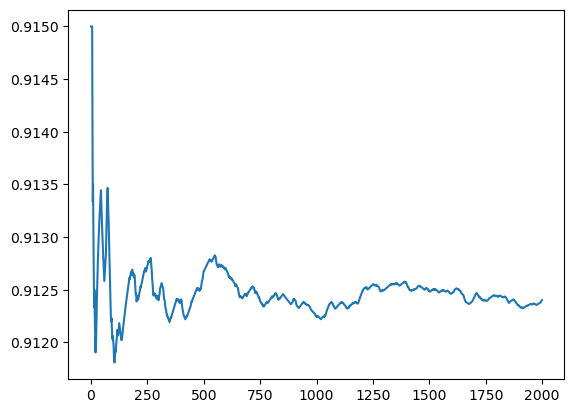

In [64]:
from matplotlib import pylab as plt
i = 1
# Initialize an empty list to store cumulative moving 
# averages 
moving_averages = [] 
  
# Store cumulative sums of array in cum_sum array 
cum_sum = np.cumsum(wn_large_df['coverage']); 
  
# Loop through the array elements 
while i <= len(wn_large_df['coverage']): 
  
    # Calculate the cumulative average by dividing 
    # cumulative sum by number of elements till  
    # that position 
    window_average = cum_sum[i-1] / i
      
    # Store the cumulative average of 
    # current window in moving average list 
    moving_averages.append(window_average) 
      
    # Shift window to right by one position 
    i += 1

plt.plot(list(range(itrial)), moving_averages)

In [66]:
0.9+1/(len(X_train)+1)

0.9012642225031606

# Testing with Solar Atl (2000 trials)

In [9]:
# Main executable function

def enbpi_exec_many_t(
    data_list,
    max_data_size,
    method,
    train_fractions,
    B_list,
    bootstrap_types,
    block_lengths,
    model_types,
    alphas,
    itrial=0,
    one_dim_list=[False],
    n_lags=1,
    output_name = "many_data",
    verbose=1,
):

    # Step 1) Extract and Clean Data
    for data_name in data_list:
        if verbose >= 1: 
            print("\n\n" + "="*80)
            print(f"data_name='{data_name}'")
        data_df, target_column = read_data(data_name, max_data_size)
        tab_str = "- "
        if verbose == 2:
            print(f"{tab_str}data_name shape:{data_df.shape}")
            print(f"{tab_str}target_column='{target_column}'")

        # STEP 2): Preprocess Data ################    
        for one_dim in one_dim_list:
            if verbose >= 1: print(f"\n{tab_str}one_dim={one_dim}")
            # Separate results output for one_dim True and False
            results_df = pd.DataFrame()
            # results_df = pd.DataFrame(columns=_get_results_columns())
            for train_fraction in train_fractions:
                tab_str = "  " + tab_str
                if verbose >= 1: print(f"\n{tab_str}train_fraction={train_fraction}")
                # 2a) Split train/test sets
                # get X and y data
                data_X = data_df.drop(target_column, axis=1)
                data_y = data_df[target_column]
                # convert X and y data to numpy
                data_X_numpy = data_X.to_numpy()
                data_y_numpy = data_y.to_numpy()
                # get train idx to split train and test
                train_size = int(len(data_df) * train_fraction)
                # split into 4
                X_train_numpy = data_X_numpy[:train_size, :]
                X_test_numpy = data_X_numpy[train_size:, :]
                y_train_numpy = data_y_numpy[:train_size]
                y_test_numpy = data_y_numpy[train_size:]
                # 2b) Get AR coeffs (optional)
                if one_dim:
                    X_train, X_test, y_train, y_test = one_dimen_transform(
                        y_train_numpy,
                        y_test_numpy,
                        n_lags=n_lags,  # d
                    )
                else:
                    X_train = X_train_numpy.copy()
                    X_test = X_test_numpy.copy()
                    y_train = y_train_numpy.copy()
                    y_test = y_test_numpy.copy()
                tab_str = "  " + tab_str
                if verbose == 2: 
                    print(f"{tab_str}X_train shape: {X_train.shape}")
                    print(f"{tab_str}X_test shape: {X_test.shape}")
                    print(f"{tab_str}y_train shape: {y_train.shape}")
                    print(f"{tab_str}y_test shape: {y_test.shape}")

                # STEP 3) Bootstrap Synthetic Data ################
                for trial in range(itrial):
                    for B in B_list:
                        for bootstrap_type in bootstrap_types:
                            for block_length in block_lengths:
                                if verbose >= 1:
                                    print(f"{tab_str}B={B}, bootstrap_type='{bootstrap_type}', block_length={block_length}")
                                n = len(X_train)
                                n1 = len(X_test)
                                m = n
                                # tot_trial = 1    # For CP method that randomizes (for EnbPI, should be set to 1)
                                  # for tot_trial in range(tot_trial)
                                random_seed = B + trial
                                boot_samples_idx = generate_bootstrap_samples(
                                    n=n,
                                    m=m,
                                    B=B,
                                    bootstrap_type=bootstrap_type,
                                    block_length=block_length,
                                    random_seed=random_seed,
                                )
                                tab_str = "  " + tab_str
                                if verbose == 2: print(f"{tab_str}Bootstrap samples indexes shape: {boot_samples_idx.shape}")
                                # print(boot_samples_idx)

                                # STEP 4) Train Bootstrapped Models ################
                                # tab_str = "  " + tab_str    
                                for model_type in model_types:
                                    # if verbose >= 1: print(f"{tab_str}model_type='{model_type}'")
                                    # hold predictions from each f^b
                                    boot_predictions = np.zeros((B, (n + n1)), dtype=float)
                                    # for i^th column, it shows which f^b uses i in training (so exclude in aggregation)
                                    in_boot_sample = np.zeros((B, n), dtype=bool)
                                    for b in range(B):
                                        X_train_boot = X_train[boot_samples_idx[b], :]
                                        y_train_boot = y_train[boot_samples_idx[b],]
                                        model = initiate_regressor(model_type)
                                        model.fit(
                                            X_train_boot,
                                            y_train_boot,
                                            # epochs=10,
                                            # batch_size=bsize,
                                            # callbacks=[callback],
                                            # verbose=0,
                                        )
                                        # Model's prediction for every observation on every bootstrapped data
                                        boot_predictions[b] = model.predict(np.r_[X_train, X_test]).flatten()
                                        # Whether a observation in the training data is sampled for the given bootstrapped data
                                        # If it is true, then this observation should NOT be used for model prediction
                                        in_boot_sample[b, boot_samples_idx[b]] = True
                                    tab_str = "  " + tab_str
                                    if verbose == 2:
                                        print(f"{tab_str}boot_predictions shape: {boot_predictions.shape}")
                                        print(f"{tab_str}in_boot_sample shape: {in_boot_sample.shape}")

                                    # STEP 5) LOO Predict and Mean Aggregate
                                    y_in_pred = np.zeros(n)          # Mean aggregated predict on in-sample train set
                                    y_LOO_preds = np.zeros((n, n1))  # Non-aggregated predict on OOS test set
                                    y_pred = np.zeros(n1)            # Aggregated predict on OOS test set

                                    ensemble_online_resid = np.array([])    # LOO scores
                                    # LOO in-sample train predict and OOS test predict 
                                    for i in range(n):
                                        b_keep = np.argwhere(~(in_boot_sample[:, i])).reshape(-1)
                                        if len(b_keep) > 0:
                                            # Get the LOO predictions for i for both in-sample and OOS
                                            y_train_LOO_boot_preds = boot_predictions[b_keep, i]
                                            y_in_pred[i] = y_train_LOO_boot_preds.mean()  # Mean aggregate to form a scalar value
                                            y_LOO_boot_preds = boot_predictions[b_keep, n:]
                                            y_LOO_preds[i] = y_LOO_boot_preds.mean(0)
                                        else:  # if aggregating an empty set of models, predict zero everywhere
                                            if verbose == 2: print(f"{tab_str}  WARNING: no bootstrapped models available for i={i}")
                                    y_pred = y_LOO_preds.mean(0)
                                    if verbose == 2:
                                        print(f"{tab_str}y_in_pred shape: {y_in_pred.shape}")
                                        print(f"{tab_str}y_pred shape: {y_pred.shape}")
                                        print(f"{tab_str}  y_LOO_preds shape: {y_LOO_preds.shape}")

                                    # STEP 6) Aggregate Model with LOO
                                    for alpha in alphas:
                                        # if verbose >= 1: print(f"{tab_str}alpha={alpha}")
                                        # Get absolute residual and sort
                                        abs_resid = np.abs(np.subtract(y_train, y_in_pred))
                                        abs_resid.sort()
                                        # Get q-hat value
                                        q_idx = int(-len(abs_resid)*alpha)
                                        q_hat = abs_resid[q_idx]
                                        # Evaluation metric 1: PI width
                                        width = round(q_hat*2, 6)
                                        tab_str = "  " + tab_str
                                        if verbose == 2: print(f"{tab_str}width={width}")

                                        # STEP 7) Get Coverage Rate from Test
                                        # Get OOS absolute residual and sort
                                        oos_abs_resid = np.abs(np.subtract(y_test, y_pred))
                                        oos_abs_resid.sort()
                                        # Count number of residuals below or equal to q_hat, or within the interval width.
                                        n_coverage = np.asarray(oos_abs_resid <= q_hat).sum()
                                        # Evaluation metric 2: Coverage rate
                                        coverage = round(n_coverage/n1, 6)
                                        if verbose == 2: print(f"{tab_str}coverage={coverage}")
                                        """
                                        NOTE: I am using the symmetical conformal prediction (like in NP), instead of the
                                              fancy method that Chen did. That is why the coverage rate is near the 
                                              theroretical guarantee limit of 2*alpha.
                                        """

                                        #### STEP 8) Output Results
                                        results_row = {
                                            "data_name": data_name,
                                            "one_dim": one_dim,
                                            "itrial": trial,
                                            "train_fraction": train_fraction,
                                            "B": B,
                                            "bootstrap_type": bootstrap_type,
                                            "block_length": block_length,
                                            "model_type": model.__class__.__name__,  # "muh_fun"
                                            "method": method,
                                            "alpha": alpha,
                                            "width": width,    
                                            "coverage": coverage,
                                        }
                                        results_df = pd.concat([results_df, pd.DataFrame([results_row])], ignore_index=True)

                                        tab_str = tab_str[2:]
                                    tab_str = tab_str[2:]
                                tab_str = tab_str[2:]
                    tab_str = tab_str[4:]

    results_df.to_csv(f'Results/{output_name}_many_trial.csv', index=False)

In [10]:
# Params
# Step 1) params
# cali_cities = ["Palo_Alto"]
# data_list = _get_cali_cities()
# data_list = ["Solar_Atl"] + cali_cities + ["appliances", "Beijing_air"]
data_list = ["Solar_Atl"]
#max_data_size = 10000

# Step 2) params
train_fractions = [0.8]
# train_fractions = [0.1, 0.2]
# train_fractions = [0.5, 0.6, 0.7, 0.8]
# train_fractions = [0.3, 0.4, 0.5, 0.6, 0.7]  # EnbPI WP Pg. 8
# print(train_fractions)
# one_dim_list = [True]
one_dim_list = [True]
n_lags = 10  # 'n_lags' aka 'd` is num_lookbacks for AR-transformer

# Step 3) params
itrial = 2000
B_list = [20]  # number of bootstraps list
# B_list = [20, 25, 30, 35, 40, 45, 50]  # EnbPI WP Pg. 11: between 20-50 is sufficient
# bootstrap_types = ["random", "moving"]  # "nonoverlapping" has problem -> IndexError: index 851 is out of bounds for axis 0 with size 851
bootstrap_types = ["moving"]
block_lengths = [80]
# block_lengths = [6, 12, 24, 48, 60, 72]

# Step 4) params
# model_types = ["ridge", "random_forest"]  # muh_fun
model_types = ["lasso"]  # "neural_networks"
method = "Ensemble"

# Step 6) params
alphas = [0.1]
# alphas = [0.05, 0.1, 0.15, 0.2, 0.25]  # EnbPI WP Pg. 17: five equally spaces 1-a [0.75, 0.95] are chosen
# alphas = [0.01, 0.10, 0.20, 0.50, 0.80, 0.90, 0.99]
# alphas = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]

# Step 8) params
output_name = "Solar_Atl"
verbose = 2  # 0 no print statement, 1 only params, 2 everything

In [11]:
%%time
# Execute!

enbpi_exec_many_t(
    # Step 1) Extract and Clean Data
    data_list=data_list,
    max_data_size=max_data_size,
    # Step 2) Preprocess Data
    train_fractions=train_fractions,
    one_dim_list=one_dim_list,
    n_lags=n_lags,
    # Step 3) Preprocess Data
    itrial=itrial,
    B_list=B_list,
    bootstrap_types=bootstrap_types,
    block_lengths=block_lengths,
    # STEP 4) Train Bootstrapped Models
    model_types=model_types,
    method=method,
    # STEP 6) Get Conformal Prediction Interval
    alphas=alphas,
    # STEP 8) Output Results
    output_name=output_name,
    verbose=verbose,
)



data_name='Solar_Atl'
- data_name shape:(8759, 8)
- target_column='DHI'

- one_dim=True

  - train_fraction=0.8
    - X_train shape: (6997, 10)
    - X_test shape: (1752, 10)
    - y_train shape: (6997,)
    - y_test shape: (1752,)
    - B=20, bootstrap_type='moving', block_length=80
      - Bootstrap samples indexes shape: (20, 6997)
        - boot_predictions shape: (20, 8749)
        - in_boot_sample shape: (20, 6997)
        - y_in_pred shape: (6997,)
        - y_pred shape: (1752,)
        -   y_LOO_preds shape: (6997, 1752)
          - width=201.19073
          - coverage=0.9817349999999999
- B=20, bootstrap_type='moving', block_length=80
  - Bootstrap samples indexes shape: (20, 6997)
    - boot_predictions shape: (20, 8749)
    - in_boot_sample shape: (20, 6997)
    - y_in_pred shape: (6997,)
    - y_pred shape: (1752,)
    -   y_LOO_preds shape: (6997, 1752)
      - width=201.628111
      - coverage=0.9817349999999999
B=20, bootstrap_type='moving', block_length=80
  Bootstra

In [12]:
solar_trial_df=pd.read_csv(f'Results/Solar_Atl_many_trial.csv')

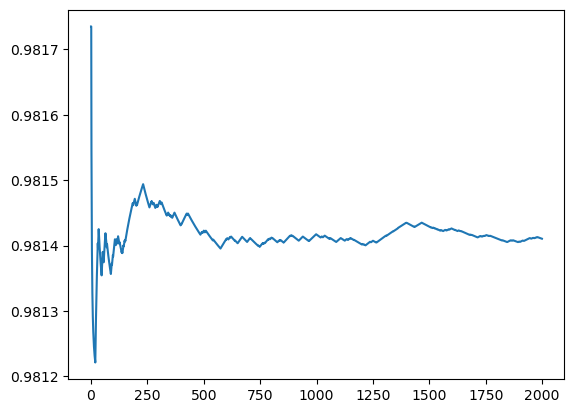

In [13]:
from matplotlib import pylab as plt
i = 1
# Initialize an empty list to store cumulative moving 
# averages 
moving_averages = [] 
  
# Store cumulative sums of array in cum_sum array 
cum_sum = np.cumsum(solar_trial_df['coverage']); 
  
# Loop through the array elements 
while i <= len(solar_trial_df['coverage']): 
  
    # Calculate the cumulative average by dividing 
    # cumulative sum by number of elements till  
    # that position 
    window_average = cum_sum[i-1] / i
      
    # Store the cumulative average of 
    # current window in moving average list 
    moving_averages.append(window_average) 
      
    # Shift window to right by one position 
    i += 1

plt.plot(list(range(itrial)), moving_averages)